# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [17]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import cm
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
import math
import bisect

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [18]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

Plotting 10 images for each number:


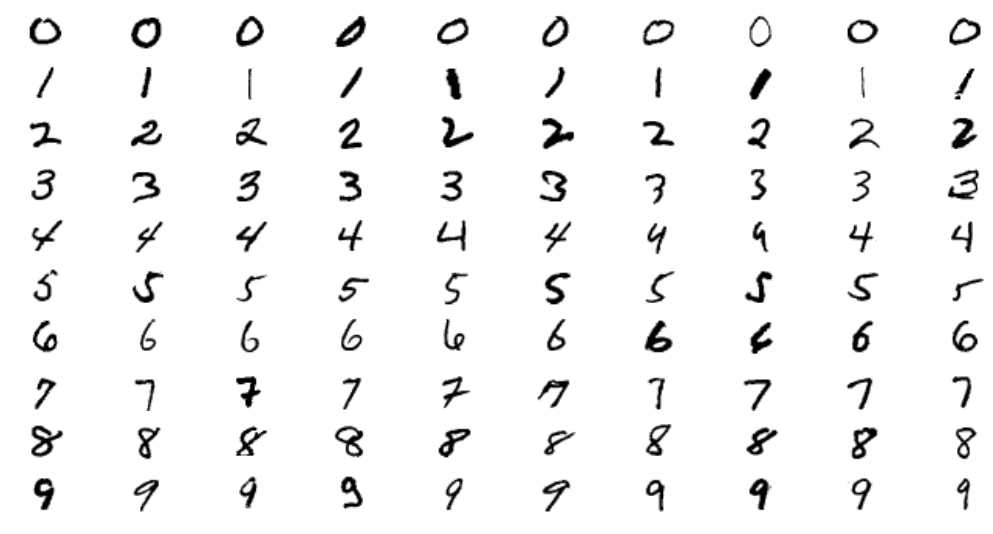

In [19]:
### STUDENT START ####

def P1(num_examples):
    print 'Plotting %d images for each number:' %(num_examples)
    # get a set of labels
    labelSet = set(Y)
    # plotting
    plt.figure(figsize=(18, 9))
    j=1
    for num in labelSet:
        # get images for this number
        numImage = X[Y == num]
        # plot the first num_examples of this number
        for i in range(num_examples):
            plt.subplot(num_examples, num_examples, j)        
            j += 1        
            plt.imshow(np.reshape(numImage[i],(28,28)), cmap = cm.gray_r)
            plt.axis('off')
    
### STUDENT END ###

P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [20]:
# my own implementation of knn classifier
#from collections import Counter

# def KNeighborsClassifier(TestImage, k, trainingData, trainingLabel):
#     # calculate distances between test image and all training data
#     aDistance = [np.sum((img - TestImage)**2) for img in trainingData]
#     # sort distance array and return index to retrieve label
#     aNN = [i[0] for i in sorted(enumerate(aDistance), key=lambda x:x[1])]
#     # get labels of k-nearest neighbors
#     knnLabels = trainingLabel[aNN[:k]]
#     # use the most common label as prediction
#     return Counter(knnLabels).most_common(1)[0][0]

# def classification_report(k):
#     # get prediction for each image in dev data
#     aPrediction = [KNeighborsClassifier(TestImage, k, mini_train_data, mini_train_labels) for TestImage in dev_data]
#     # compare prediction with actual label
#     aResults = aPrediction == dev_labels    
#     # return accuracy
#     return float(np.sum(aResults)) / aResults.shape[0]

### STUDENT START ###

# calling sklearn KNeighborsClassifier
def P2(k_values):
    for k in k_values:       
        neigh = KNeighborsClassifier(n_neighbors = k)
        neigh.fit(mini_train_data, mini_train_labels)
        predictions = neigh.predict(dev_data)        
        print 'Accuracy (k = %d): %3.2f' %(k, 1.0*np.sum(predictions == dev_labels) / dev_labels.shape[0])
        if k == 1:
            print(classification_report(dev_labels, predictions))
            
### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
P2(k_values)

Accuracy (k = 1): 0.89
             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.89      1.00      0.94       105
        2.0       0.99      0.79      0.88       102
        3.0       0.77      0.87      0.82        86
        4.0       0.89      0.82      0.85       104
        5.0       0.93      0.84      0.88        91
        6.0       0.94      0.96      0.95        98
        7.0       0.89      0.92      0.90       113
        8.0       0.94      0.88      0.91        96
        9.0       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000

Accuracy (k = 3): 0.88
Accuracy (k = 5): 0.87
Accuracy (k = 7): 0.86
Accuracy (k = 9): 0.86


ANSWER: 
- when k=1, number 3 has the lowest precision, and is the most difficult to predict.

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

Handling training size 100 ...
Handling training size 200 ...
Handling training size 400 ...
Handling training size 800 ...
Handling training size 1600 ...
Handling training size 3200 ...
Handling training size 6400 ...
Handling training size 12800 ...
Handling training size 25000 ...


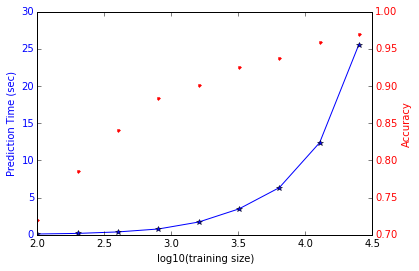

In [21]:
### STUDENT START ###

def P3(train_sizes):    
    # initialize array to record prediction time and accuracy
    ptime = np.zeros([len(train_sizes)])
    accuracy = np.zeros([len(train_sizes)])  
    # evaluate for each training size
    i = 0
    for size in train_sizes:
        print 'Handling training size %d ...' %(size)
        trainData = train_data[:size]
        trainLabel = train_labels[:size]
        neigh = KNeighborsClassifier(n_neighbors = 1)
        neigh.fit(trainData, trainLabel)
        time1 = time.time()
        prediction = neigh.predict(dev_data)
        time2 = time.time()   
        ptime[i] = time2-time1
        results = prediction == dev_labels
        accuracy[i] = 1.0*np.sum(results) / results.shape[0]  
        i += 1
    # plot accuracy and time
    xTick = [math.log10(float(i)) for i in train_sizes]
    fig, ax1 = plt.subplots()    
    ax1.plot(xTick, ptime, 'b*-')
    ax1.set_xlabel('log10(training size)')
    # Make the y-axis label and tick labels match the line color.
    ax1.set_ylabel('Prediction Time (sec)', color='b')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')
    # set axis format
    ax2 = ax1.twinx()    
    ax2.plot(xTick, accuracy, 'r.')
    ax2.set_ylabel('Accuracy', color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
    plt.show()
    return accuracy

# observation: 
# 1). prediction time grows linearly with training size, 
# 2). accuracy improves as training size grows 

### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
Accuracy = P3(train_sizes)

(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

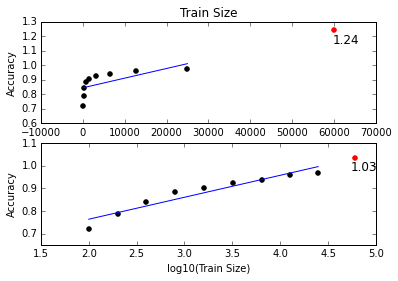

In [22]:
### STUDENT START ###
    
def P4():
    # use original train size value as input
    lrm = LinearRegression()
    sizeInput = np.reshape(train_sizes,(len(train_sizes),1))
    lrm.fit(sizeInput, Accuracy)
    
    # use log10(train size) as input
    logSizeInput = np.reshape([math.log10(float(i)) for i in train_sizes],(len(train_sizes),1))
    lrmLog = LinearRegression()
    lrmLog.fit(logSizeInput, Accuracy)
    
    # plot regression line and fitting data (with original training size value)
    plt.subplot(211)
    plt.scatter(train_sizes, Accuracy, color='black')
    plt.plot(train_sizes, lrm.predict(sizeInput))
    plt.scatter(60000, lrm.predict(60000), color='red')
    plt.text(60000, 1.15, "%.2f" % lrm.predict(60000)[0], fontsize = 12)
    plt.title('Train Size')
    plt.ylabel('Accuracy')
    
    # plot regression line and fitting data (with log10(training size) as input value)
    plt.subplot(212)
    plt.scatter(logSizeInput, Accuracy , color='black')
    plt.plot(logSizeInput, lrmLog.predict(logSizeInput))
    plt.scatter(math.log10(float(60000)), lrmLog.predict(math.log10(float(60000))), color='red')
    plt.text(math.log10(float(57000)), .98, "%.2f" % lrmLog.predict(math.log10(float(60000))), fontsize=12)
    plt.xlabel('log10(Train Size)')
    plt.ylabel('Accuracy')
    
    # observations:
    # 1). training size and accuracy share no linear relationship, therefore linear regression is not appropriate, 
    #     and the prediction for 60000 goes way above 1. 
    # 2). Take log10 of train size will improve the model, although prediction of 60000 also exceeds 1, 
    #     but it's very close, and the accuracy can be considered very close to 1.

### STUDENT END ###

P4()

ANSWER:
- Train size and accuracy share no linear relationship, therefore linear regression is not appropriate, and the prediction for 60000 goes way above 1. 
- Take log10 of train size will improve the model, although prediction of 60000 also exceeds 1, but it's very close, and the accuracy can be considered very close to 1.

(5) Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

Mean accuracy: 0.888000
Confusion matrix for dev data with 1-NN on mini train data:
[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1   0  94   0   0   0]
 [  1   4   0   1   1   0   0 104   0   2]
 [  0   2   0   5   0   2   1   0  84   2]
 [  1   0   0   3   9   1   0   5   0  87]]

Images of #4 that were confused as #9:


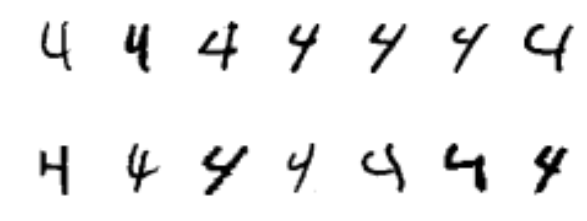


Images of #5 that were confused as #3:


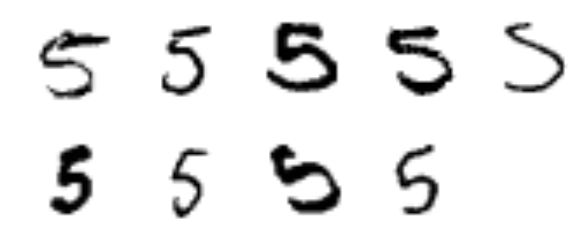


Images of #9 that were confused as #4:


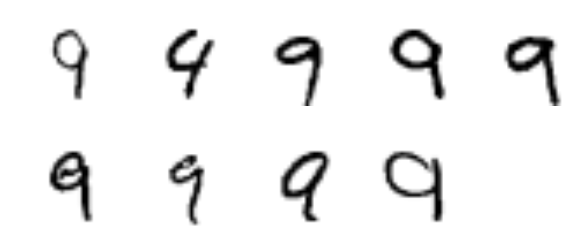

In [35]:
### STUDENT START ###

def P5():
    # train a 1-nn classifier with mini train data
    neigh = KNeighborsClassifier(n_neighbors = 1)
    neigh.fit(mini_train_data, mini_train_labels)
    # predict on dev data
    prediction = neigh.predict(dev_data)
    print 'Mean accuracy: %2f' %(neigh.score(dev_data, dev_labels))
    print 'Confusion matrix for dev data with 1-NN on mini train data:'
    # evaluate confusion matrix
    cm_1nnNoBlur = confusion_matrix(dev_labels, prediction)  
    print cm_1nnNoBlur
    
    # according to the confusion matrix, there are most (14) #4 that were misclassified as #9
    confuseImage = dev_data[np.array(prediction == 9.0) & np.array(dev_labels == 4.0)]
    print '\nImages of #4 that were confused as #9:'
    plt.figure(figsize=(10, 4))
    for i in range(len(confuseImage)):
        plt.subplot(2, 7, i+1)   
        plt.imshow(np.reshape(confuseImage[i],(28,28)), cmap = cm.gray_r)
        plt.axis('off')
    plt.show()
    
    # and #5 that were misclassified as #3
    confuseImage = dev_data[np.array(prediction == 3.0) & np.array(dev_labels == 5.0)]
    print '\nImages of #5 that were confused as #3:'
    plt.figure(figsize=(10, 4))
    for i in range(len(confuseImage)):
        plt.subplot(2, 5, i+1)   
        plt.imshow(np.reshape(confuseImage[i],(28,28)), cmap = cm.gray_r)
        plt.axis('off')
    plt.show()
        
    # and #5 that were misclassified as #3
    confuseImage = dev_data[np.array(prediction == 4.0) & np.array(dev_labels == 9.0)]
    print '\nImages of #9 that were confused as #4:'
    plt.figure(figsize=(10, 4))
    for i in range(len(confuseImage)):
        plt.subplot(2, 5, i+1)   
        plt.imshow(np.reshape(confuseImage[i],(28,28)), cmap = cm.gray_r)
        plt.axis('off')
        
    # return the confusion matrix for later comparison with blur
    return cm_1nnNoBlur

### STUDENT END ###

cm_1nnNoBlur = P5()

# 4 & 9 are the most confused pair
# 5 & 3 also have 9 misclassifications


(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.


preprocess the training data but not the dev data
confusion matrix difference with 1-nn without blur (blur - no blur)
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0 -1  1  0  0  0  0  0  0  0]
 [-1 -2  5  0  0  0  0 -1  0 -1]
 [-1  0  1  0  0  1  0 -1  1 -1]
 [ 0 -2  0  0  1  0 -1  2  1 -1]
 [ 0  0  0 -2  0  5  0 -1  0 -2]
 [ 1  0 -1  0  0  0  0  0  0  0]
 [-1 -3  0  1  0  0  0  1  0  2]
 [ 0 -1  1 -2  0 -1 -1  0  5 -1]
 [ 0  0  0  0 -4  0  0 -2  0  6]]
Mean accuracy 0.910000

preprocess the dev data but not the training data
confusion matrix difference with 1-nn without blur (blur - no blur)
[[  0   0   0   0   0   0   0   0   0   0]
 [  0  -1   1   0   0   0   0   0   0   0]
 [ -1   2   2  -1   0   1   0  -1  -1  -1]
 [  0   2   0  -2   0   1   0   0   0  -1]
 [  0   0   0   0   4   0   0   0   0  -4]
 [ -1   1   0  -2   1   1   0   1   0  -1]
 [  0   2  -1   0   0   0  -1   0   0   0]
 [ -1   7   0   0  -1   1   0  -7   0   1]
 [  0   6   0   3   0  -1   0   1 -12   3]
 [  0   0   0   0  -1

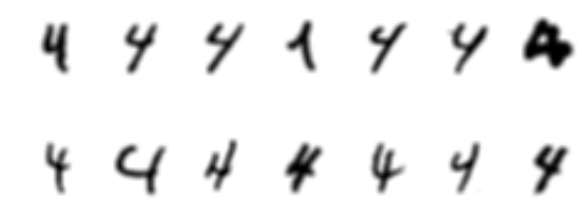

In [36]:
### STUDENT START ###

# ref for Gaussian Blur: http://www.pixelstech.net/article/1353768112-Gaussian-Blur-Algorithm

# define the Gaussian weights of neighbors as constant variable
sigma2 = 1.5**2
neighborIndex = [[i,j] for i in range(-1,2) for j in range(-1,2)]
gaussianWeight = [math.exp(-(x**2+y**2)/(2*sigma2))/(2*math.pi*sigma2) for [x,y] in neighborIndex]
temp = sum(gaussianWeight)
gaussianWeight = [ i / temp for i in gaussianWeight]

# function to return the index of neighborhood pixels for pixel at n
def getNeighborAndWeight(n, ncolumn, nrow):    
    # get row and column id first for index i
    (r, c) = divmod(n, ncolumn)
    # get indices for the neighbors (including self)
    neighbors = [[r+i,c+j] for [i,j] in neighborIndex]
    # get neighbor index and the associated Gauusian weigth
    neighborWeights = []
    for i in range(len(neighbors)):
        r,c = neighbors[i]
        if r>=0 and r<nrow and c>=0 and c<ncolumn:                  
            neighborWeights.append([r*ncolumn + c, gaussianWeight[i]])
    return neighborWeights

# apply Gaussian blur to one image
def gaussianBlurOneSample(x):
    y = np.empty(len(x))
    for i in range(len(x)):
        neighbors = getNeighborAndWeight(i,28,28)
        y[i] = (sum([x[j[0]]*j[1] for j in neighbors]))
    return y
        
def P6():
    # Blur mini training set
    blurTrainData = np.array([gaussianBlurOneSample(x) for x in mini_train_data])
    # Blur dev set
    blurDevData = np.array([gaussianBlurOneSample(x) for x in dev_data])
    # use 1-NN
    neigh = KNeighborsClassifier(n_neighbors = 1)
    print '\npreprocess the training data but not the dev data'    
    print 'confusion matrix difference with 1-nn without blur (blur - no blur)'
    neigh.fit(blurTrainData, mini_train_labels)
    prediction = neigh.predict(dev_data)
    print confusion_matrix(dev_labels, prediction) - cm_1nnNoBlur
    print 'Mean accuracy %2f' %(neigh.score(dev_data, dev_labels))
    
    print '\npreprocess the dev data but not the training data'  
    print 'confusion matrix difference with 1-nn without blur (blur - no blur)'
    neigh.fit(mini_train_data, mini_train_labels)
    prediction = neigh.predict(blurDevData)
    print confusion_matrix(dev_labels, prediction) - cm_1nnNoBlur
    print 'Mean accuracy %2f' %(neigh.score(dev_data, dev_labels))
    
    print '\npreprocess both training and dev data'    
    print 'confusion matrix difference with 1-nn without blur (blur - no blur)'
    neigh.fit(blurTrainData, mini_train_labels)
    prediction = neigh.predict(blurDevData)
    print confusion_matrix(dev_labels, prediction) - cm_1nnNoBlur
    print 'Mean accuracy %2f' %(neigh.score(dev_data, dev_labels))
    
    # plot Images of 4 that was confused as 9
    confuseImage = blurDevData[np.array(prediction == 9.0) & np.array(dev_labels == 4.0)]
    print '\nImages of 4 that were confused as 9:'
    plt.figure(figsize=(10, 4))
    for i in range(14):
        plt.subplot(2, 7, i+1)   
        plt.imshow(np.reshape(confuseImage[i],(28,28)), cmap = cm.gray_r)
        plt.axis('off')
    
### STUDENT END ###


P6()


(-0.5, 27.5, 27.5, -0.5)

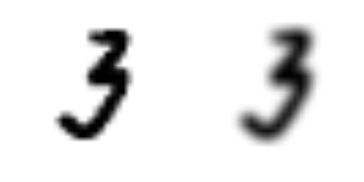

In [38]:
# testing blur effect - unrelated to the assignment
imageID = 4138
plt.subplot(121)
plt.imshow(np.reshape(X[imageID],(28,28)), cmap = cm.gray_r)
plt.axis('off')
test = gaussianBlurOneSample(X[imageID])
plt.subplot(122)
plt.imshow(np.reshape(test,(28,28)), cmap = cm.gray_r)
plt.axis('off')
# looks like it's blurred ok

ANSWER: 
- we print the difference between confusion matrix after and before applying blur, ideally if blur improves classification results, we want to see positive number on diagonal positions, and negative number on off-diagonal position.
- we also compare the overall mean accuracy of the classification, without blur it's 0.888 given by P5
- and the result are below:

- 1). preprocess the training data but not the dev data: accuracy improves to 0.91
- 2). preprocess the dev data but not the training data: no improvement on accuracy, it remains 0.888
- 3). preprocess both training and dev data: accuracy also improves to 0.91

- both 1 and 3 have some significant improvement on diagnoal values of confustion matrix, while 2 has some issue with classifying digit 8 and 7
- all 3 approaches have reduced misclassification rate (negative off-diag values) for majority of the digits
- and it's still 4 & 9 are most confusing to the classifier

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

Bernoulli NP...
             precision    recall  f1-score   support

        0.0       0.86      0.97      0.91        99
        1.0       0.86      0.95      0.90       105
        2.0       0.86      0.78      0.82       102
        3.0       0.62      0.76      0.68        86
        4.0       0.89      0.76      0.82       104
        5.0       0.88      0.58      0.70        91
        6.0       0.88      0.88      0.88        98
        7.0       0.93      0.73      0.82       113
        8.0       0.70      0.80      0.75        96
        9.0       0.67      0.82      0.74       106

avg / total       0.82      0.81      0.81      1000


Images of 5 that were confused as 3:


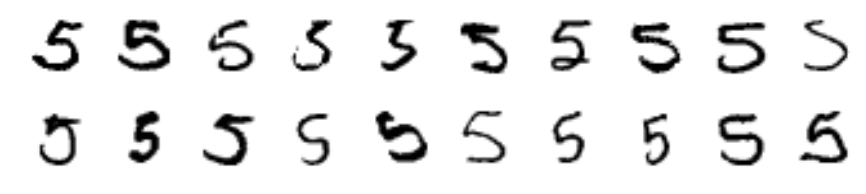


Images of 7 that were confused as 9:


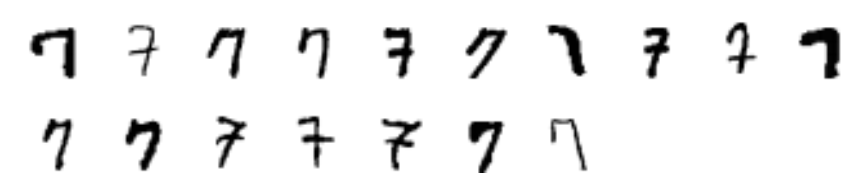

Multinomial NB...
             precision    recall  f1-score   support

        0.0       0.88      0.95      0.91        99
        1.0       0.91      0.91      0.91       105
        2.0       0.83      0.78      0.81       102
        3.0       0.64      0.73      0.68        86
        4.0       0.88      0.68      0.77       104
        5.0       0.83      0.59      0.69        91
        6.0       0.86      0.91      0.89        98
        7.0       0.95      0.73      0.83       113
        8.0       0.64      0.76      0.70        96
        9.0       0.62      0.83      0.71       106

avg / total       0.81      0.79      0.79      1000


Images of 7 that were confused as 9:


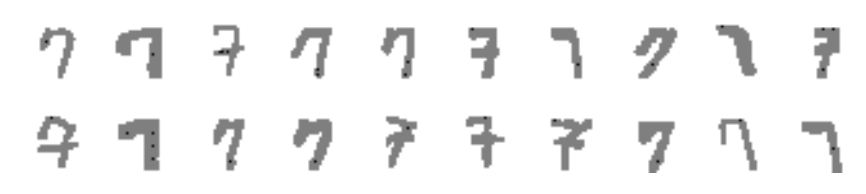


Images of 4 that were confused as 9:


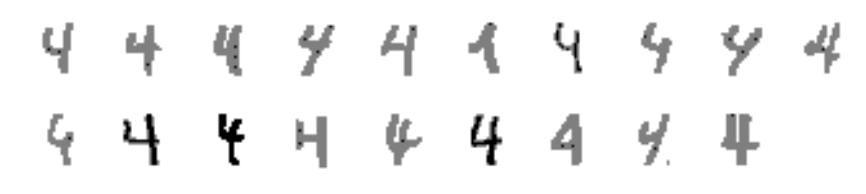

In [41]:
### STUDENT START ###

def P7_B():
    print 'Bernoulli NP...'
    clf = BernoulliNB(alpha = 1, binarize = 0, fit_prior = True)
    clf.fit(mini_train_data, mini_train_labels)
    predictions = clf.predict(dev_data)
    print classification_report(dev_labels, predictions)
#     print confusion_matrix(dev_labels, predictions)  

    # plot Images of 5 that was confused as 3
    confuseImage = dev_data[np.array(predictions == 3.0) & np.array(dev_labels == 5.0)]
    print '\nImages of 5 that were confused as 3:'
    plt.figure(figsize=(15, 3))
    for i in range(20):
        plt.subplot(2, 10, i+1)   
        plt.imshow(np.reshape(confuseImage[i],(28,28)), cmap = cm.gray_r)
        plt.axis('off')
    plt.show()

    # plot Images of 7 that was confused as 9
    confuseImage = dev_data[np.array(predictions == 9.0) & np.array(dev_labels == 7.0)]
    print '\nImages of 7 that were confused as 9:'
    plt.figure(figsize=(15, 3))
    for i in range(17):
        plt.subplot(2, 10, i+1)   
        plt.imshow(np.reshape(confuseImage[i],(28,28)), cmap = cm.gray_r)
        plt.axis('off')
    plt.show()

def P7_M():
    print 'Multinomial NB...'
    # data preprocessing - recode 
    # original scale: 0 white; 1 black; else grey
    # mapping scale:  0 while; 2 black; 1 grey
    mini_train_BGW = mini_train_data.copy()
    mini_train_BGW[mini_train_BGW==1] = 2
    mini_train_BGW[np.array(mini_train_BGW!=2) & np.array(mini_train_BGW!=0)] = 1
    dev_BGW = dev_data.copy()
    dev_BGW[dev_BGW==1] = 2
    dev_BGW[np.array(dev_BGW!=2) & np.array(dev_BGW!=0)] = 1
    # Multinormial NB
    clf2 = MultinomialNB()
    clf2.fit(mini_train_BGW, mini_train_labels)
    predictions2 = clf2.predict(dev_BGW)
    print classification_report(dev_labels, predictions2)
#     print confusion_matrix(dev_labels, predictions2)  
    
    # plot Images of 7 that was confused as 9
    confuseImage = dev_BGW[np.array(predictions2 == 9.0) & np.array(dev_labels == 7.0)]
    print '\nImages of 7 that were confused as 9:'
    plt.figure(figsize=(15, 3))
    for i in range(len(confuseImage)):
        plt.subplot(2, 10, i+1)   
        plt.imshow(np.reshape(confuseImage[i],(28,28)), cmap = cm.gray_r)
        plt.axis('off')
    plt.show()
    
    # plot Images of 4 that was confused as 9
    confuseImage = dev_BGW[np.array(predictions2 == 9.0) & np.array(dev_labels == 4.0)]
    print '\nImages of 4 that were confused as 9:'
    plt.figure(figsize=(15, 3))
    for i in range(len(confuseImage)):
        plt.subplot(2, 10, i+1)   
        plt.imshow(np.reshape(confuseImage[i],(28,28)), cmap = cm.gray_r)
        plt.axis('off')
    plt.show()
    
### STUDENT END ###

P7_B()
P7_M()

ANSWER:
- multinomial NB has worse performance than binary NB classifier, all performance metrics have dropped a bit.
- from the sample plots, we can see after recoding the image to black grey white format, most pixels of an image have the grey value, thus we are actually reduce the "span" of an image in the feature space, thus with lower variation, it becomes more difficult for a multinomial classifier to predict

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [47]:
### STUDENT START ###

def P8(alphas):
    nb = BernoulliNB(binarize=0.0)
    clf = GridSearchCV(nb, alphas)
    clf.fit(mini_train_data, mini_train_labels)
    nb1 = clf.best_estimator_
    # evaluate accuracy for best estimator
    print 'Best model:' 
    print nb1
    pred1 = clf.predict(dev_data)  # using the best parameter
    print 'Mean accuracy of the best estimator: %2f' %(clf.score(dev_data, dev_labels))
    print classification_report(pred1, dev_labels)
    

    # evaluate accuracy for alpha=0    
    print 'Evaluate Bernoulli NB without smoothing ...'
    nb0 = BernoulliNB(alpha=0, binarize=0.0)    
    nb0.fit(mini_train_data, mini_train_labels)
    pred0 = nb0.predict(dev_data)
    print 'Accuracy without smoothing: %2f' %(nb0.score(dev_data, dev_labels)) 
    print classification_report(pred0, dev_labels)

    return clf

### STUDENT END ###

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)


Best model:
BernoulliNB(alpha=0.0001, binarize=0.0, class_prior=None, fit_prior=True)
Mean accuracy of the best estimator: 0.813000
             precision    recall  f1-score   support

        0.0       0.95      0.92      0.94       102
        1.0       0.93      0.93      0.93       105
        2.0       0.81      0.75      0.78       110
        3.0       0.77      0.65      0.70       102
        4.0       0.75      0.90      0.82        87
        5.0       0.67      0.76      0.71        80
        6.0       0.88      0.89      0.88        97
        7.0       0.77      0.92      0.84        95
        8.0       0.76      0.72      0.74       102
        9.0       0.82      0.72      0.77       120

avg / total       0.82      0.81      0.81      1000

Evaluate Bernoulli NB without smoothing ...
Accuracy without smoothing: 0.099000
             precision    recall  f1-score   support

        0.0       1.00      0.10      0.18      1000
        1.0       0.00      0.00      0.0

In [48]:
print nb.best_params_

{'alpha': 0.0001}


ANSWER: 
- the best Bernoulli NB has a smoothing factor of 0.0001
- Bernoulli NB performance is very bad without smoothing, because we don't have enough training data to cover all 784 dimensions in the feature space, therefore the conditional probability can be zeros for many pixels, and the prediction will become zero whenever there are zero conditional probabilities.
- for effective performance, we should apply smoothing to avoid above situation

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [62]:
### STUDENT END ###

def P9():
    # fit a Gaussian NB
    clf = GaussianNB()
    clf.fit(mini_train_data, mini_train_labels)
    print 'Classification report without blur:'
    print classification_report(clf.predict(dev_data), dev_labels)

    print '\nUsing Blurred image ...'
    # Blur mini train data
    blurTrainData = np.array([gaussianBlurOneSample(x) for x in mini_train_data])
    clf.fit(blurTrainData, mini_train_labels)
    print 'Classification report with blur training set:'
    print classification_report(clf.predict(dev_data), dev_labels)
    return clf


### STUDENT END ###

gnb = P9()

Classification report without blur:
             precision    recall  f1-score   support

        0.0       0.84      0.76      0.80       109
        1.0       0.89      0.82      0.85       113
        2.0       0.40      0.62      0.49        66
        3.0       0.47      0.62      0.53        64
        4.0       0.39      0.80      0.53        51
        5.0       0.37      0.52      0.44        65
        6.0       0.88      0.69      0.77       124
        7.0       0.50      0.85      0.63        67
        8.0       0.61      0.41      0.49       144
        9.0       0.88      0.47      0.61       197

avg / total       0.70      0.63      0.64      1000


Using Blurred image ...
Classification report with blur training set:
             precision    recall  f1-score   support

        0.0       0.93      0.76      0.84       121
        1.0       0.94      0.62      0.75       160
        2.0       0.30      0.78      0.44        40
        3.0       0.43      0.73      0.5

ANSWER: 
- peformance is not good because, similarly, there are many value of theta are zeros.
- to improve performance, we use blurred training data
- from the classification report we can see the precision is significantly improved, while accuracy has improvement for some digits, but accuracy particularly got worse for digit 1

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

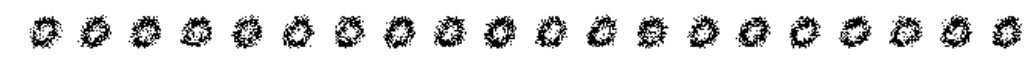

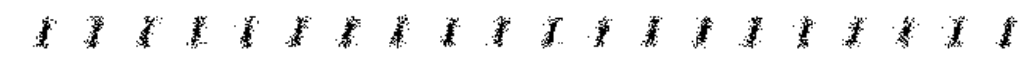

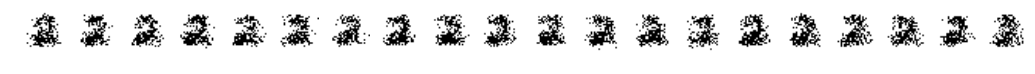

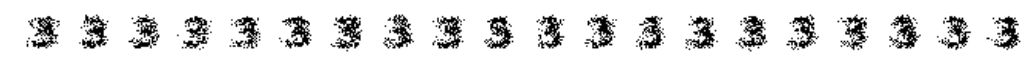

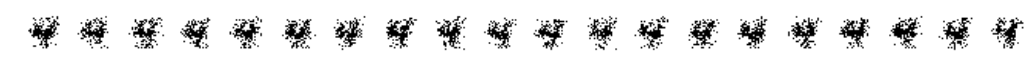

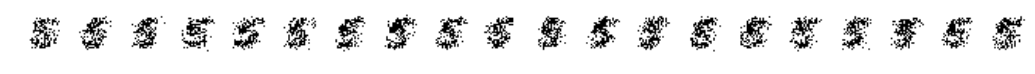

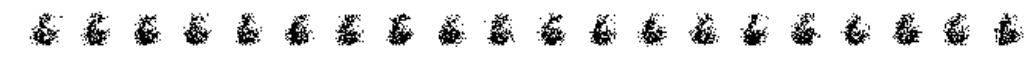

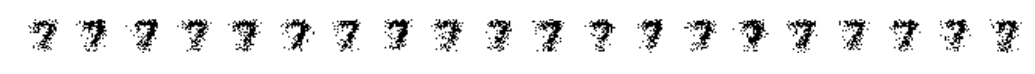

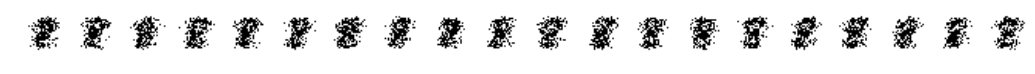

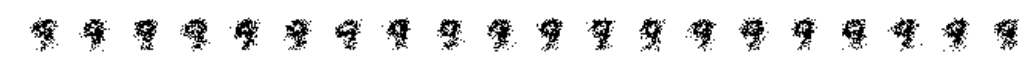

In [11]:
### STUDENT START ###
# session 3.7

def P10(num_examples):
    clf = BernoulliNB(binarize = 0.0, alpha = 0.001)
    # training with mini data set
    clf.fit(mini_train_data, mini_train_labels)
    # get feature probability (likelihood)
    features_prob = np.exp(clf.feature_log_prob_)
    # generate digits for each number
    nNumber = len(set(mini_train_labels))
    i = 1    
    for num in range(nNumber):
        # for each feature, generate 20 binary samples based on feature probability
        digits = np.transpose(np.array([np.random.rand(num_examples)<x for x in features_prob[num]]))
        # plot each digit
        plt.figure(figsize=(18, 9))
        for digit in digits:
            plt.subplot(nNumber, num_examples, i)
            plt.imshow(np.reshape(digit,(28,28)), cmap = cm.gray_r)
            plt.axis('off')
            i += 1

### STUDENT END ###

P10(20)

ANSWER: 
- because the sample size 20 is relatively small, so the randomly generated pixels is hard to represent the conditional probability, thus the generated images are very fuzzy compare with the training digits and are barely recognizable.

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

p(pred) <= 0.5000000000000    total =   0    accuracy = 0.000
p(pred) <= 0.9000000000000    total =  30    accuracy = 0.267
p(pred) <= 0.9990000000000    total =  86    accuracy = 0.465
p(pred) <= 0.9999900000000    total =  78    accuracy = 0.603
p(pred) <= 0.9999999000000    total =  61    accuracy = 0.689
p(pred) <= 0.9999999990000    total =  56    accuracy = 0.786
p(pred) <= 0.9999999999900    total =  68    accuracy = 0.794
p(pred) <= 0.9999999999999    total =  69    accuracy = 0.884
p(pred) <= 1.0000000000000    total = 552    accuracy = 0.947


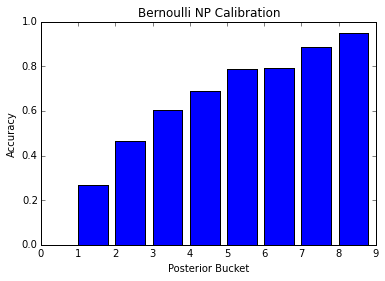

In [61]:
### STUDENT START ###

def P11(buckets, correct, total):
    clf = BernoulliNB(alpha = 0.001, binarize = 0.5)
    # training with mini set
    clf.fit(mini_train_data, mini_train_labels)
    # get posterior for dev data
    posteriors = clf.predict_proba(dev_data)
    # get confidence of the prediction
    confidence = np.amax(posteriors, axis=1)
    # get correctness of the prediction
    bCorrect = np.argmax(posteriors, axis=1) == dev_labels
    # find bucket for each prediction    
    for i in range(len(dev_labels)):
        bucket = bisect.bisect_left(buckets, confidence[i])
        total[bucket] += 1
        if bCorrect[i]:
            correct[bucket] += 1
    # return accuracy
    return [c/float(t) if t>0 else 0 for t,c in zip(total, correct)]
                    
### STUDENT END ###


buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

calib = P11(buckets, correct, total)

for i in range(len(buckets)):   
    print 'p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], calib[i])

plt.bar(range(len(calib)), calib)
plt.xlabel('Posterior Bucket')
plt.ylabel('Accuracy')
plt.title('Bernoulli NP Calibration')

ANSWER: 
- as accuracy increases when the posteriors grows, the classifier is well calibrated with 0.5 as binarize variable

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [94]:
### STUDENT START ###

def addFeatures(digit):
    # sum row and column to add 28x2=56 features
    rtn = digit.copy()
    sqr = np.reshape(digit, (28,28))
    return np.concatenate([rtn, np.sum(sqr, axis = 0), np.sum(sqr, axis = 1)])
    

def P12():
    # add feature for training and dev data
    newTrain = [addFeatures(x) for x in mini_train_data]
    newDev = [addFeatures(x) for x in dev_data]
    # build Bernoulli NP model
    clf = BernoulliNB(binarize=.5, alpha=.001)
    clf.fit(newTrain, mini_train_labels)
    
    clf2 = BernoulliNB(binarize = 0.5, alpha = 0.001)
    clf2.fit(mini_train_data, mini_train_labels)
    print 'Accuracy with added features: %.3f' %(clf.score(newDev, dev_labels))
    print 'Accuracy without added features: %.3f' %(clf2.score(dev_data, dev_labels))
    

### STUDENT END ###

P12()

Accuracy with added features: 0.824
Accuracy without added features: 0.819


(28, 28)
(28, 28)


(-0.5, 27.5, 27.5, -0.5)

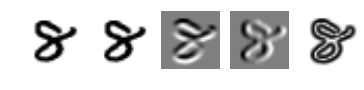

In [123]:
import scipy.ndimage as ndimage
im = np.zeros((256, 256))
im[64:-64, 64:-64] = 1
# im = ndimage.rotate(im, 15, mode='constant')
im = np.reshape(X[6],(28,28))
plt.subplot(151)
plt.imshow(im, cmap = cm.gray_r)
plt.axis('off')
# im = ndimage.gaussian_filter(im, 8)
plt.subplot(152)
plt.imshow(im, cmap = cm.gray_r)
plt.axis('off')

sx = ndimage.sobel(im, axis=0, mode='constant')
plt.subplot(153)
plt.imshow(sx, cmap = cm.gray_r)
plt.axis('off')

sy = ndimage.sobel(im, axis=1, mode='constant')
plt.subplot(154)
plt.imshow(sy, cmap = cm.gray_r)
plt.axis('off')

sob = np.hypot(sx, sy)
print sob.shape
print sx.shape
plt.subplot(155)
plt.imshow(sob, cmap = cm.gray_r)
plt.axis('off')